In [76]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

In [77]:
df_X = pd.read_csv('../data/X.csv', index_col=0)
df_y = pd.read_csv('../data/y.csv', index_col=0)

X = df_X.to_numpy()
y = df_y.values.ravel()

In [78]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score
from scipy.stats import randint as sp_randint
import time

def optimize_rfc_grid_search(x_data, y_targets):
    # Random Forest classifier to be optimized
    rfc = RandomForestClassifier(random_state=2)

    # Step 1: Define the parameter space for RandomizedSearchCV
    param_dist = {
        "n_estimators": sp_randint(10, 750),
        "max_leaf_nodes": sp_randint(20, 1000),
        "max_depth": sp_randint(20, 500),
        "min_samples_split": sp_randint(2, 250),
        "max_features": sp_randint(3, 100)
    }

    # Step 2: Execute RandomizedSearchCV
    n_iter_search = 50  # Number of parameter settings that are sampled
    random_search = RandomizedSearchCV(rfc, param_distributions=param_dist,
                                       n_iter=n_iter_search, scoring=make_scorer(f1_score, average='micro'), cv=4, verbose=1)
    
    start_time = time.time()
    random_search.fit(x_data, y_targets)

    print(f"Random Search completed in {time.time() - start_time:.2f} seconds. Starting Grid Search...")

    # Step 3: Identify the best parameters from the random search
    best_params = random_search.best_params_

    # Step 4: Define a narrower search space for GridSearchCV around the best parameters found
    param_grid = {
        "n_estimators": [best_params['n_estimators'] - 3, best_params['n_estimators'], best_params['n_estimators'] + 3],
        "max_leaf_nodes": [best_params['max_leaf_nodes'] - 5, best_params['max_leaf_nodes'], best_params['max_leaf_nodes'] + 5],
        "max_depth": [best_params['max_depth'] - 5, best_params['max_depth'], best_params['max_depth'] + 5],
        "min_samples_split": [best_params['min_samples_split'] - 3, best_params['min_samples_split'], best_params['min_samples_split'] + 3],
        "max_features": [max(1, best_params['max_features'] - 3), best_params['max_features'], best_params['max_features'] + 4]
    }

    # Step 5: Execute GridSearchCV
    grid_search = GridSearchCV(rfc, param_grid=param_grid, scoring=make_scorer(f1_score, average='micro'), cv=4, verbose=1)

    # Adjust ranges to ensure they are valid (e.g., positive integers)
    for key in param_grid.keys():
        param_grid[key] = [np.max([x, param_dist[key].a]) for x in param_grid[key]]  # Ensure within original bounds

    start_time = time.time()

    grid_search.fit(x_data, y_targets)

    print(f"Grid Search completed in {time.time() - start_time:.2f} seconds.")

    # Step 6: Report the best parameters found
    print("Best parameters found by grid search:", grid_search.best_params_)
    return grid_search.best_params_

# Call the function with your data and target variables
# best_params = optimize_rfc_with_random_and_grid_search(x_data, y_targets)

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

In [111]:
m_rf = RandomForestClassifier(n_estimators = 20, max_features = 3).fit(X_train, y_train)
y_pred_std = m_rf.predict(X_test)

print(classification_report(y_test, y_pred_std, zero_division=0))

              precision    recall  f1-score   support

           0       0.50      0.31      0.38        13
           1       0.27      0.38      0.32         8
           2       0.27      0.33      0.30         9

    accuracy                           0.33        30
   macro avg       0.35      0.34      0.33        30
weighted avg       0.37      0.33      0.34        30



In [82]:
best_params = optimize_rfc_grid_search(X_train, y_train)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Random Search completed in 29.58 seconds. Starting Grid Search...
Fitting 4 folds for each of 243 candidates, totalling 972 fits
Grid Search completed in 145.20 seconds.
Best parameters found by grid search: {'max_depth': 300, 'max_features': 60, 'max_leaf_nodes': 905, 'min_samples_split': 6, 'n_estimators': 314}


In [123]:
m_rf_optimized = RandomForestClassifier(n_estimators = int(best_params["n_estimators"]), max_depth = int(best_params["max_depth"]), max_leaf_nodes = int(best_params["max_leaf_nodes"]), min_samples_split = int(best_params["min_samples_split"]), max_features = int(best_params["max_features"])).fit(X_train, y_train)
y_pred = m_rf_optimized.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.78      0.54      0.64        13
           1       0.33      0.50      0.40         8
           2       0.44      0.44      0.44         9

    accuracy                           0.50        30
   macro avg       0.52      0.49      0.49        30
weighted avg       0.56      0.50      0.52        30



In [97]:
def feature_importance(model, X_train):

    # Extract feature importances
    feature_importances = model.feature_importances_

    # Create generic feature names if not already provided
    if hasattr(X_train, 'columns'):
        feature_names = X_train.columns
    else:
        feature_names = [f"{i}" for i in range(X_train.shape[1])]

    # Sort the feature importances in descending order and get the indices
    indices = np.argsort(feature_importances)[::-1]

    # Select the top 50 features
    top_indices = indices[:100]
    
    # Adjust the size of the plot to accommodate 50 features nicely
    plt.figure(figsize=(15, 10))
    plt.title("Top 50 Feature Importances")
    plt.bar(range(100), feature_importances[top_indices], color="r", align="center")
    
    # Set the ticks to be the names of the top 50 features
    plt.xticks(range(100), [feature_names[i] for i in top_indices], rotation=90)
    plt.xlim([-1, 100])
    plt.tight_layout()  # Adjust layout to not cut off labels
    plt.show()

    return top_indices

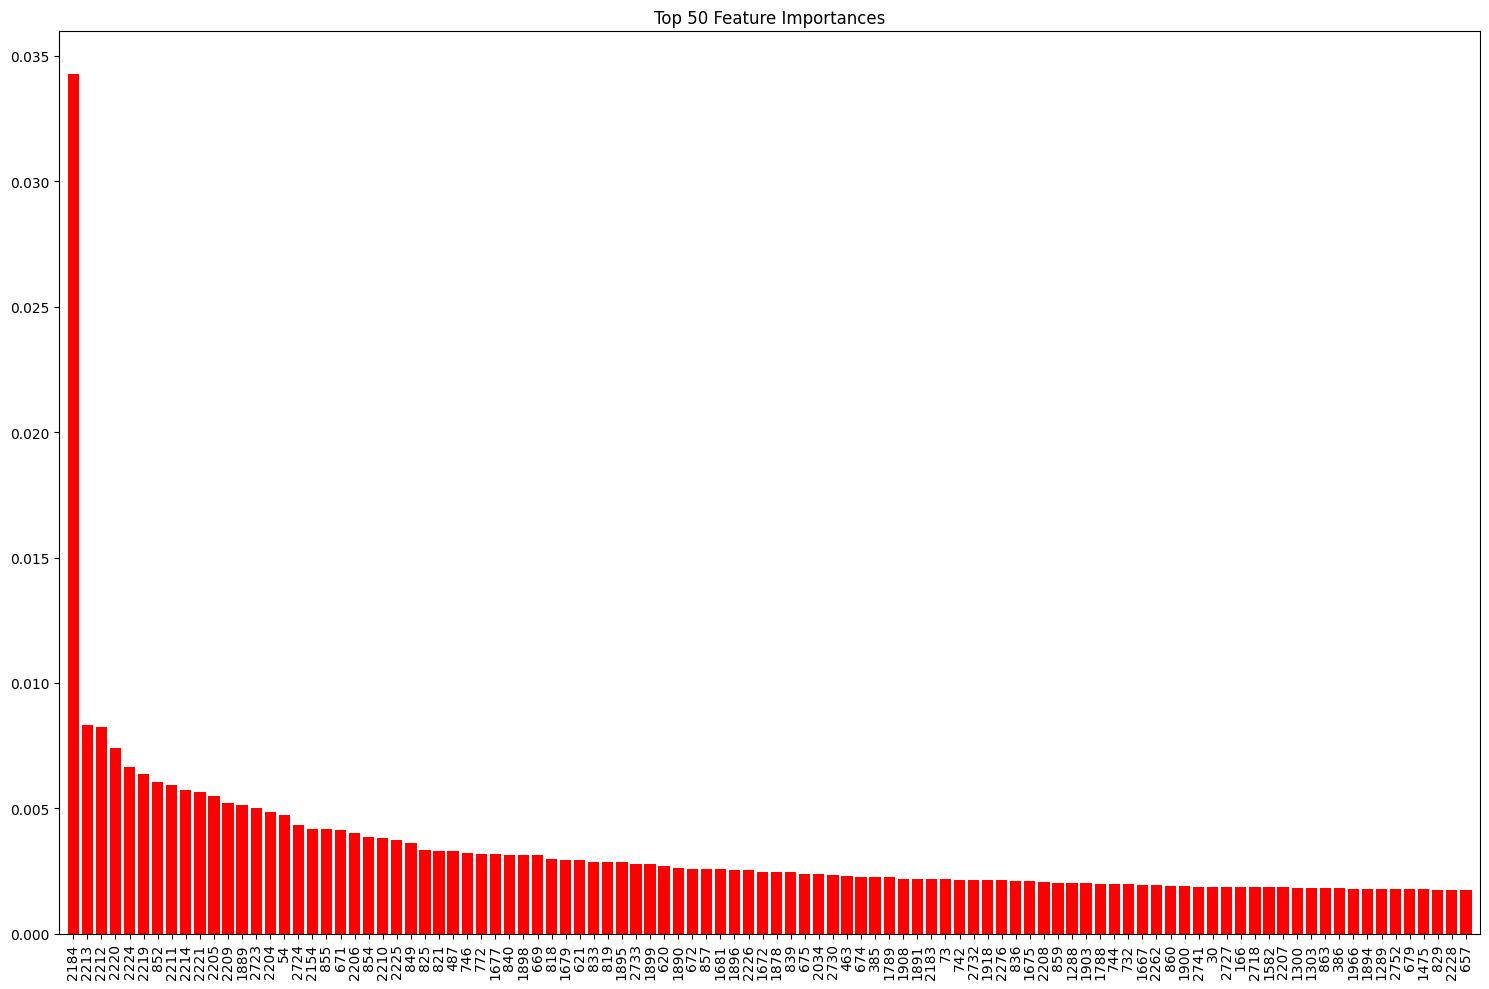

In [102]:
top_features_rf = feature_importance(m_rf_optimized, X_train)

In [105]:
top_features_rf

top_features_l1 = [30, 31, 175, 177, 192, 194, 223, 230, 316, 317, 342, 354, 396, 472, 485, 487, 509, 511, 623, 672, 679, 758, 764, 766, 791, 814, 815, 842, 998, 1035, 1055, 1059, 1170, 1243, 1310, 1481, 1642, 1655, 1659, 1663, 1678, 1679, 1683, 1788, 1897, 1899, 1902, 1906, 1907, 1962, 2017, 2023, 2024, 2026, 2184, 2188, 2206, 2207, 2210, 2211, 2213, 2382, 2427, 2457, 2501, 2655, 2656, 2742, 2747, 2750, 2752]

In [124]:
def calculate_similarity(list1, list2):
    # Convert lists to sets
    set1 = set(list1)
    set2 = set(list2)
    
    # Calculate intersection and union
    intersection = set1 & set2
    union = set1 | set2
    
    # Calculate Jaccard similarity index
    if len(union) == 0:  # Prevent division by zero
        similarity = 0
    else:
        similarity = len(intersection) / len(union)
    
    return similarity, list(intersection)

# Example usage:
list_a = [1, 2, 3, 4, 5]
list_b = [4, 5, 6, 7, 8]

similarity, intersection = calculate_similarity(list_a, list_b)
print("Similarity index:", similarity)
print("Intersection of lists:", intersection)


Similarity index: 0.25
Intersection of lists: [4, 5]


In [125]:
calculate_similarity(top_features_rf, top_features_l1)

(0.08917197452229299,
 [672,
  2752,
  2210,
  2211,
  2213,
  679,
  2184,
  487,
  1899,
  1679,
  2206,
  1788,
  30,
  2207])